Przygotowanie bibliotek, połączenie z dyskiem i plikiem csv:

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
base_path = Path('/content/drive/MyDrive/Colab Notebooks/titanic.csv')
titanic_data = pd.read_csv(base_path)

Mounted at /content/drive


Jeszcze na szybko przekształce dane jednak:
*   Płeć: 1 - male, 0 - female
*   Port: 1 - C, 2 - Q, 3 - S

In [2]:
titanic_data["Sex"] = titanic_data["Sex"].map({"male": 1, "female": 0})
titanic_data["Embarked"] = titanic_data["Embarked"].map({"C": 1, "Q": 2, "S": 3})
titanic_data.to_csv("titanic.csv", index=False)

Przypomnijmy niektóre moje wnioski:

*   Więcej kobiet przeżywało
*   Ludzie z lepszych klas częściej przeżywali
*   Starsi ludzie częściej kupowali lepszą klasę
*   Najdroższe bilety były w porcie C kobiet a najtańsze dla portu Q
*    Częściej przeżywali pasażerowie, którzy nie byli sami

A także kolumny, które są istotne w analizie danych:

In [3]:
print(titanic_data.head())
titanic_data.dtypes.reset_index().rename(columns={"index": "Kolumna", 0: "Typ"})

   PassengerId  Survived  Pclass  Sex  Age   Fare  Embarked  WithSomeone
0            1         0       3    1   22   7.25         3            1
1            2         1       1    0   38  71.28         1            1
2            3         1       3    0   26   7.92         3            0
3            4         1       1    0   35  53.10         3            1
4            5         0       3    1   35   8.05         3            0


,Kolumna,Typ
0,PassengerId,int64
1,Survived,int64
2,Pclass,int64
3,Sex,int64
4,Age,int64
5,Fare,float64
6,Embarked,int64
7,WithSomeone,int64


Podział na dane treningowe i testowe będzie w stosunku 80/20

In [4]:
from sklearn.model_selection import train_test_split

X = titanic_data.drop('Survived', axis=1)
y = titanic_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Dla porównania model DummyClassifier z metryką "prior" - zgadywanie klasy proporcjonalnie do ich częstości występowania:

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy = DummyClassifier(strategy='prior')
dummy.fit(X_train, y_train)
y_predicted = dummy.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)

print("Accuracy of Dummy Classifier:", round(accuracy*100,2), "%")

Accuracy of Dummy Classifier: 61.45 %


A teraz model drzewa decyzyjnego:

In [6]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

y_predicted_train = tree_model.predict(X_train)
y_predicted_test = tree_model.predict(X_test)

print("Accuracy of Decision Tree Classifier - training:", round(accuracy_score(y_train, y_predicted_train)*100, 2), "%")
print("Accuracy of Decision Tree Classifier - test:", round(accuracy_score(y_test, y_predicted_test)*100, 2), "%")


Accuracy of Decision Tree Classifier - training: 83.29 %
Accuracy of Decision Tree Classifier - test: 78.21 %


Wniosek jest taki, że model drzewa decyzyjnego w porónaniu do "głupiego modelu" jest lepszym rozwiązaniem i widać to po dokładności działania wyrażonej w procentach.

Ocena tego modelu przez zewnętrzne metryki:

In [7]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted_test))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       110
           1       0.83      0.55      0.66        69

    accuracy                           0.78       179
   macro avg       0.80      0.74      0.75       179
weighted avg       0.79      0.78      0.77       179



Dla przypomnienia: 0 - nie przeżył

Wnioski:
*   Precyzja rzeczywista dobrze wypadła (77% i 83%)
*   Natomiast w przypadku przewidywań modelu świetnie poradziło sobie drzewo z przewidywaniem zgonów (93%), ale znacznie gorzej z wykrywaniem przeżyć (55%)
*   Porónanie precyzji i pokrycia jest dla wykrywania zgonów całkiem dobre (84%)
*   Ostatecznie podel zgał 78% przypadków poprawnie, co jest przyzwoitym wynikiem


Teraz spróbuję wykorzystać model KNN z metryką podobieństwa kosinusowego oraz euklidesowego:

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn_cos_model = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_dist_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_cos_model.fit(X_train, y_train)
knn_dist_model.fit(X_train, y_train)
y_knnCOS_predicted = knn_cos_model.predict(X_test)
y_knnDIST_predicted = knn_dist_model.predict(X_test)

print("Accuracy of KNN cosine Classifier:", round(accuracy_score(y_test, y_knnCOS_predicted)*100, 2), "%")
print(classification_report(y_test, y_knnCOS_predicted))
print("Accuracy of KNN distance Classifier:", round(accuracy_score(y_test, y_knnDIST_predicted)*100, 2), "%")
print(classification_report(y_test, y_knnDIST_predicted))


Accuracy of KNN cosine Classifier: 62.57 %
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       110
           1       0.52      0.43      0.47        69

    accuracy                           0.63       179
   macro avg       0.60      0.59      0.59       179
weighted avg       0.62      0.63      0.62       179

Accuracy of KNN distance Classifier: 62.01 %
              precision    recall  f1-score   support

           0       0.66      0.78      0.72       110
           1       0.51      0.36      0.42        69

    accuracy                           0.62       179
   macro avg       0.59      0.57      0.57       179
weighted avg       0.60      0.62      0.60       179



Wnioski:
Z porównania tych dwóch metryk metody KNN widać, że są bardzo podobne do siebie i lepiej wykrywają zgony niż przeżywalności (~71,5% do 44,5%), jedna jak widać istnieją lepsze metody w przypadku zadania Titanica (choćby drzewo decyzyjne).

Jeżeli chodzi o hiperparametry to:

*   W przypadku Drzewa decyzyjnego były to: maksymalna głębokość drzewa oraz minimalna liczba próbek, do podziału drzewa
*   W przypadu KNN: liczba sąsiadów oraz metryka odległości



Dla drzewa decyzyjnego może zmieniać się na przykład hiperparametr minimalnej głębokości drzewa:

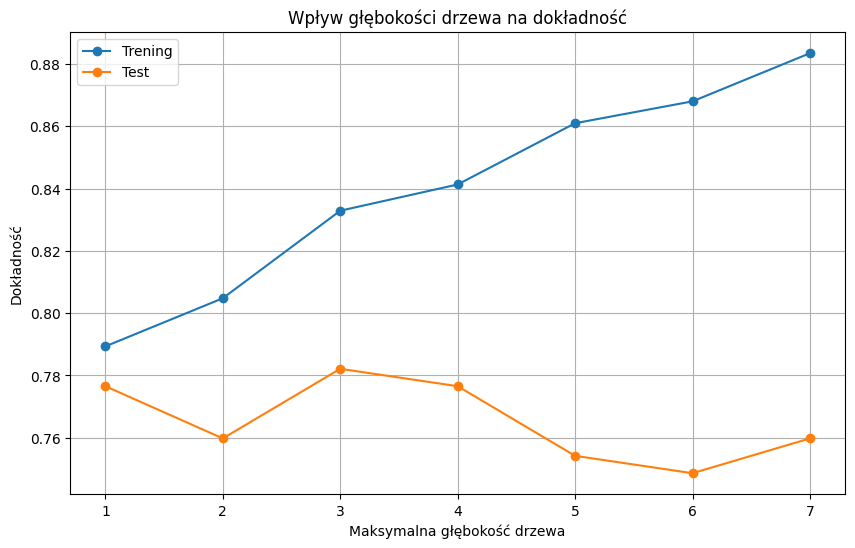

In [15]:
depths = [1,2,3,4,5,6,7]
training_accuracy = []
test_accuracy = []

for d in depths:
  tree_model = DecisionTreeClassifier(max_depth=d, random_state=42)
  tree_model.fit(X_train, y_train)
  training_accuracy.append(accuracy_score(y_train, tree_model.predict(X_train)))
  test_accuracy.append(accuracy_score(y_test, tree_model.predict(X_test)))

plt.figure(figsize=(10,6))
plt.plot(depths, training_accuracy, label="Trening", marker="o")
plt.plot(depths, test_accuracy, label="Test", marker="o")
plt.xlabel("Maksymalna głębokość drzewa")
plt.ylabel("Dokładność")
plt.title("Wpływ głębokości drzewa na dokładność")
plt.legend()
plt.grid(True)
plt.show()

Wniosek jest taki, że im większa głębokość drzewa dla danych treningowych, to większa dokładność w predykcji, że ktoś przeżył. Możemy przewidywać, że dla dalszych głębokości osiągnie 100% - overfitting będzie wtedy. W przypadku zbyt małej głębokości widać underfitting.
Natomiast dla danych testowych jest to tendencja ciężka do jednoznacznego opisania (niemonotoniczna), ale wydaje się jakby spadkowa. Z wykresu widać, że najlepsze dopasowanie jest dla głębokości równej 3 (~83% i ~78%).